In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path

import sys
sys.path.insert(0, '../completenessContours')
import compute_num_completeness_w_ve_insol as kp

sys.path.insert(0, '..')
import occRateUtils as ut

import rateModels3D as rm3D

In [2]:
stellarType = "hab2"
catalog = "dr25"
hzType = "optimistic"

if stellarType == "hab":
    teffRange = (4800, 6300)
elif stellarType == "hab2":
    teffRange = (3900, 6300)
elif stellarType == "GK":
    teffRange = (3900, 6000)
elif stellarType == "FGK":
    teffRange = (3900, 7300)
else:
    raise ValueError('Bad catalog name');
    
cs = rm3D.compSpace(periodName = "Insolation", 
               periodUnits = "Earth Flux",
               periodRange = (0.2, 2.2), 
               nPeriod = 61, 
               radiusName = "Radius", 
               radiusUnits = "$R_\oplus$",
               rpRange = (0.5, 2.5), 
               nRp = 61,
               tempName = "$T_\mathrm{eff}$", 
               tempUnits = "$R_\oplus$",
               tempRange = teffRange, 
               nTemp = 10)

model = rm3D.triplePowerLawTeffAvg(cs)


outputDir = "caseComparison"



In [16]:
capsize = 8
cbc = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
def draw_dists(dr25, hr, hc, fpwg, xlimMax, drawLegend = False):
    plt.figure(figsize=(15,6));
    ylim = plt.ylim()
    plt.hist(hr, 50, histtype="step", linewidth=2, color=cbc[0], density=True);
    plt.hist(hc, 50, histtype="step", linewidth=2, color=cbc[1], density=True);
    plt.hist(fpwg, 50, histtype="step", linewidth=2, color=cbc[2], density=True);
    plt.hist(dr25, 50, histtype="step", linewidth=2, color=cbc[3], density=True);
    ylim = plt.ylim()
    # plt.xscale('log')
    xlim = plt.xlim()
    plt.xlim(xlim[0], xlimMax)
    hrStats = ut.medianAndErrorbars(hr)
    hcStats = ut.medianAndErrorbars(hc)
    fpwgpcStats = ut.medianAndErrorbars(fpwg)
    dr25Stats = ut.medianAndErrorbars(dr25)
    l1 = plt.errorbar(dr25Stats[0], 1.04*ylim[1], xerr=[[dr25Stats[2]],[dr25Stats[1]]], capsize = capsize, color = cbc[3], fmt='--d')
    l2 = plt.errorbar(hrStats[0], 1.02*ylim[1], xerr=[[hrStats[2]],[hrStats[1]]], capsize = capsize, color = cbc[0], fmt='--o')
    l3 = plt.errorbar(hcStats[0], 1.0*ylim[1], xerr=[[hcStats[2]],[hcStats[1]]], capsize = capsize, color = cbc[1], fmt='--s')
    l4 = plt.errorbar(fpwgpcStats[0], 0.98*ylim[1], xerr=[[fpwgpcStats[2]],[fpwgpcStats[1]]], capsize = capsize, color = cbc[2], fmt='--*')
    plt.gca().set_yticklabels([])
    plt.tick_params(labelsize = 24)
    if drawLegend:
        plt.legend([l1, l2, l3, l4], ["DR25", "High Reliability", "High Completeness", "FPWG PC"], fontsize=24)
    
    medianVec = [hrStats[0], hcStats[0], fpwgpcStats[0], dr25Stats[0]]
    sigmaVecPlus = [hrStats[1], hcStats[1], fpwgpcStats[1], dr25Stats[1]]
    sigmaVecMinus = [hrStats[2], hcStats[2], fpwgpcStats[2], dr25Stats[2]]
    sigmaVec = [sigmaVecPlus,sigmaVecMinus]
    
    separation = np.zeros((len(medianVec), len(medianVec)))
    separationSigma = np.zeros((len(medianVec), len(medianVec)))
    separationInSigma = np.zeros((len(medianVec), len(medianVec)))
    for i in range(len(medianVec)):
        for j in range(i):
            separation[i,j] = np.abs(medianVec[i]-medianVec[j])
            if medianVec[i] > medianVec[j]:
                # i > j, so use i minus and j plus
                separationSigma[i,j] = np.sqrt(sigmaVecMinus[i]**2 + sigmaVecPlus[j]**2)
            else:
                # i <= j, so use i plus and j minus
                separationSigma[i,j] = np.sqrt(sigmaVecPlus[i]**2 + sigmaVecMinus[j]**2)
            if separationSigma[i,j] > 0:
                separationInSigma[i,j] = separation[i,j]/separationSigma[i,j]
            
#     print(separation)
#     print(separationSigma)
#     print(separationInSigma)
            
    print("Range of medians: " 
         + str(np.round(np.min(medianVec),2)) + " to " + str(np.round(np.max(medianVec),2)))
    print("std of medians: " 
         + str(np.round(np.std(medianVec),2)) + " = " + str(np.round(100*np.std(medianVec)/np.mean(medianVec),2)) + "%")
    print("peak-to-peak of medians: " 
         + str(np.round(np.ptp(medianVec),2)) + " = " + str(np.round(100*np.ptp(medianVec)/np.mean(medianVec),2)) + "%")
    print("peak-to-peak of medians: " 
         + str(np.round(np.ptp(medianVec),2)) + " = " + str(np.round(np.ptp(medianVec)/np.linalg.norm(sigmaVec),2)) + " sigma")
    print("Maximum separation of medians: " + str(np.round(np.max(separationInSigma), 3)) + " sigma")

    

In [13]:
str1 = "computeOccurrencefixedTeff_"
str2 = "_hab2_triplePowerLawTeffAvg_optimistic_extrap_zero_out"

hrPosteriorsNoReliability = np.load(str1 + "highreliability" + str2 + "/occurenceRatePosteriors_noreliability.npy")
hrPosteriorsWithReliability = np.load(str1 + "highreliability" + str2 + "/occurenceRatePosteriors.npy")

hcPosteriorsNoReliability = np.load(str1 + "highcompleteness" + str2 + "/occurenceRatePosteriors_noreliability.npy")
hcPosteriorsWithReliability = np.load(str1 + "highcompleteness" + str2 + "/occurenceRatePosteriors.npy")

fpwgpcPosteriorsNoReliability = np.load(str1 + "fpwgpc" + str2 + "/occurenceRatePosteriors_noreliability.npy")
fpwgpcPosteriorsWithReliability = np.load(str1 + "fpwgpc" + str2 + "/occurenceRatePosteriors.npy")

dr25PosteriorsNoReliability = np.load(str1 + "dr25" + str2 + "/occurenceRatePosteriors_noreliability.npy")
dr25PosteriorsWithReliability = np.load(str1 + "dr25" + str2 + "/occurenceRatePosteriors.npy")


In [14]:
print("F_0 High Reliability Without Reliability = " + ut.printMedianAndErrorbars(hrPosteriorsNoReliability[:,0]))
print("F_0 High Reliability With Reliability = " + ut.printMedianAndErrorbars(hrPosteriorsWithReliability[:,0]))

print("F_0 High Completeness Without Reliability = " + ut.printMedianAndErrorbars(hcPosteriorsNoReliability[:,0]))
print("F_0 High Completeness With Reliability = " + ut.printMedianAndErrorbars(hcPosteriorsWithReliability[:,0]))

print("F_0 fpwgpc Without Reliability = " + ut.printMedianAndErrorbars(fpwgpcPosteriorsNoReliability[:,0]))
print("F_0 fpwgpc With Reliability = " + ut.printMedianAndErrorbars(fpwgpcPosteriorsWithReliability[:,0]))

print("F_0 DR25 Without Reliability = " + ut.printMedianAndErrorbars(dr25PosteriorsNoReliability[:,0]))
print("F_0 DR25 With Reliability = " + ut.printMedianAndErrorbars(dr25PosteriorsWithReliability[:,0]))


F_0 High Reliability Without Reliability = 1.183^{+0.759}_{-0.410}
F_0 High Reliability With Reliability = 0.778^{+0.579}_{-0.287}
F_0 High Completeness Without Reliability = 2.768^{+1.848}_{-1.021}
F_0 High Completeness With Reliability = 0.881^{+0.686}_{-0.349}
F_0 fpwgpc Without Reliability = 2.736^{+1.832}_{-1.038}
F_0 fpwgpc With Reliability = 0.931^{+0.745}_{-0.367}
F_0 DR25 Without Reliability = 2.767^{+1.880}_{-0.986}
F_0 DR25 With Reliability = 1.462^{+1.182}_{-0.593}


Range of medians: 1.18 to 2.77
std of medians: 0.68 = 28.84%
peak-to-peak of medians: 1.58 = 67.04%
peak-to-peak of medians: 1.58 = 0.42 sigma
Maximum separation of medians: 1.273 sigma


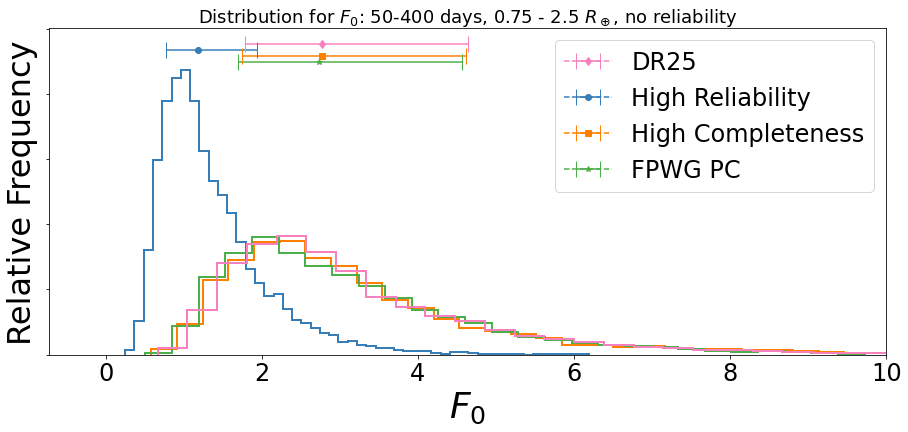

In [17]:
draw_dists(dr25PosteriorsNoReliability[:,0], hrPosteriorsNoReliability[:,0], hcPosteriorsNoReliability[:,0], 
           fpwgpcPosteriorsNoReliability[:,0], 10, drawLegend=True)
plt.xlabel(r"$F_0$", fontSize = 36);
plt.ylabel("Relative Frequency", fontSize = 32);
plt.savefig(outputDir + "/f0DistNoReliabilityRVVariations.pdf",bbox_inches='tight')
plt.title("Distribution for $F_0$: 50-400 days, 0.75 - 2.5 $R_\oplus$, no reliability", fontsize=18);


Range of medians: 0.78 to 1.46
std of medians: 0.26 = 26.15%
peak-to-peak of medians: 0.68 = 67.48%
peak-to-peak of medians: 0.68 = 0.37 sigma
Maximum separation of medians: 0.825 sigma


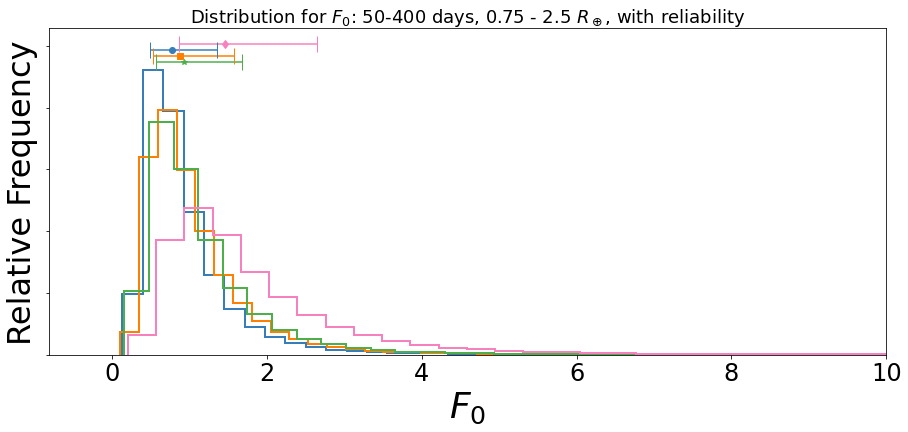

In [18]:
draw_dists(dr25PosteriorsWithReliability[:,0], hrPosteriorsWithReliability[:,0], hcPosteriorsWithReliability[:,0], 
           fpwgpcPosteriorsWithReliability[:,0], 10)
plt.xlabel(r"$F_0$", fontSize = 36);
plt.ylabel("Relative Frequency", fontSize = 32);
plt.savefig(outputDir + "/f0DistWithReliabilityRVVariations.pdf",bbox_inches='tight')
plt.title("Distribution for $F_0$: 50-400 days, 0.75 - 2.5 $R_\oplus$, with reliability", fontsize=18);


In [10]:
def compute_deltas(d, base):
    delta = np.zeros(d.shape)
    delta[0] = d[0]-baselineZeta[0]
    if d[0] > baselineZeta[0]:
        # i > j, so use i minus and j plus
        delta[1] = np.sqrt(d[2]**2 + baselineZeta[1]**2)
    else:
        # i <= j, so use i plus and j minus
        delta[1] = np.sqrt(d[1]**2 + baselineZeta[2]**2)
    if delta[1] > 0:
        delta[2] = delta[0]/delta[1]
    return delta;

def compute_separation(medianVec, sigmaVecPlus, sigmaVecMinus):
    separation = np.zeros((len(medianVec), len(medianVec)))
    separationSigma = np.zeros((len(medianVec), len(medianVec)))
    separationInSigma = np.zeros((len(medianVec), len(medianVec)))
    for i in range(len(medianVec)):
        for j in range(i):
            separation[i,j] = np.abs(medianVec[i]-medianVec[j])
            if medianVec[i] > medianVec[j]:
                # i > j, so use i minus and j plus
                separationSigma[i,j] = np.sqrt(sigmaVecMinus[i]**2 + sigmaVecPlus[j]**2)
            else:
                # i <= j, so use i plus and j minus
                separationSigma[i,j] = np.sqrt(sigmaVecPlus[i]**2 + sigmaVecMinus[j]**2)
            if separationSigma[i,j] > 0:
                separationInSigma[i,j] = separation[i,j]/separationSigma[i,j]
    return np.max(np.max(separationInSigma))



str1 = "computeOccurrencefixedTeff_"
str2 = "_hab2_triplePowerLawTeffAvg_optimistic_extrap_zero_out"
# get the original posteriors
fitOcNames = ["F0", "alpha", "beta", "gamma"]
fitOcStr = ["$F_0$", "$\\alpha$", "$\\beta$", "$\\gamma$"]
caseNames = ["dr25", "highreliability", "highcompleteness", "fpwgpc"]
fitDataNR = np.zeros((len(fitOcNames), len(caseNames), 3))
fitDataWR = np.zeros((len(fitOcNames), len(caseNames), 3))
fitDeltaNR = np.zeros((len(fitOcNames), len(caseNames), 3))
fitDeltaWR = np.zeros((len(fitOcNames), len(caseNames), 3))
maxFitSepNR = np.zeros((len(fitOcNames)))
maxFitSepWR = np.zeros((len(fitOcNames)))
for k in range(len(caseNames)):
    for i in range(len(fitOcNames)):
        nrData=np.load(str1 + caseNames[k] + str2 + "/occurenceRatePosteriors_noreliability.npy")    
        wrData=np.load(str1 + caseNames[k] + str2 + "/occurenceRatePosteriors.npy")    
        fitDataNR[i, k, :] = ut.medianAndErrorbars(nrData[:,i])
        fitDataWR[i, k, :] = ut.medianAndErrorbars(wrData[:,i])


for k in range(len(caseNames)):
    for i in range(len(fitOcNames)):
        baselineZeta = fitDataWR[i, 0, :];
        fitDeltaNR[i, k, :] = compute_deltas(fitDataNR[i, k, :], baselineZeta)
        fitDeltaWR[i, k, :] = compute_deltas(fitDataWR[i, k, :], baselineZeta)

for i in range(len(fitOcNames)):
        maxFitSepNR[i] = compute_separation(fitDataNR[i, :, 0], fitDataNR[i, :, 1], fitDataNR[i, :, 2])
        maxFitSepWR[i] = compute_separation(fitDataWR[i, :, 0], fitDataWR[i, :, 1], fitDataWR[i, :, 2])



In [ ]:
def printMedianAndErrorbarVec(e):
    return "${:.2f}".format(e[0]) +"^{+" + "{:.2f}".format(e[1]) + "}_{-" + "{:.2f}".format(e[2]) + "}$"

print("% fit coefficients with reliability")
print("& \\multicolumn{5}{c}{With Reliability Correction} \\\\")
alphaBetaMap = [0, 2, 1, 3]
for i in range(4):
    print(fitOcStr[i]),
    for k in range(len(caseNames)):
        print("& " + printMedianAndErrorbarVec(fitDataWR[alphaBetaMap[i], k, :])),
    print("& " + "{:.2f}".format(maxFitSepWR[alphaBetaMap[i]])), 
    print("\\\\")
    
print("% fit coefficients no reliability")
print("& \\multicolumn{5}{c}{No Reliability Correction} \\\\")
alphaBetaMap = [0, 2, 1, 3]
for i in range(4):
    print(fitOcStr[i]),
    for k in range(len(caseNames)):
        print("& " + printMedianAndErrorbarVec(fitDataNR[alphaBetaMap[i], k, :])),
    print("& " + "{:.2f}".format(maxFitSepNR[alphaBetaMap[i]])), 
    print("\\\\")
    


In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
%%bash -s  "$dataStr"
jupyter nbconvert --to html compareCases.ipynb
mv compareCases.html htmlArchive/compareCases_$1.html